In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



from sklearn import ensemble, metrics, model_selection
import os



from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
#!pip install transformers
import transformers
from transformers import BertTokenizer,AutoTokenizer, TFAutoModel,BertForSequenceClassification, TFBertModel
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import copy
from sklearn.model_selection import train_test_split


os.environ["WANDB_API_KEY"] = "0" ## to silence the warning:wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.

In [ ]:
train_data = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_data = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

# **Enabling and testing the TPU:**

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

# **Modelling:**

# **XLM-RoBERTa Model: (Large)**

**Defining Parameters to be used:**

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
step = len(train_data) // BATCH_SIZE

Building The Model defination:

In [ ]:
def model_defination(strategy,transformer):
    with strategy.scope():
        encoder = TFAutoModel.from_pretrained(transformer)
        input_layer = Input(shape=(30,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]
        cls_token = sequence_output[:, 0, :]
        output_layer = Dense(3, activation='softmax')(cls_token)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            Adam(lr=1e-5), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

In [ ]:
model=model_defination(strategy,"jplu/tf-xlm-roberta-large")

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 30, 1024), (None, 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


**Tokenizing: With (xlm-roberta-large)**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

In [ ]:
train_set = train_data[['premise','hypothesis']].values.tolist()
test_set = test_data[['premise','hypothesis']].values.tolist()

**Encoding the Data:**

In [ ]:
encoded_train = tokenizer.batch_encode_plus(train_set, pad_to_max_length=True, max_length=30)
encoded_test = tokenizer.batch_encode_plus(test_set, pad_to_max_length=True, max_length=30)

Below example shows what the tokenizer has done to the first sentence at "premise[0]":

In [ ]:
train_data.premise.values[0]

'and these comments were considered in formulating the interim rules.'

Below is the few tokens from the above sentence:

In [ ]:
print(encoded_train.input_ids[0][0:30])

[0, 136, 6097, 24626, 3542, 90698, 23, 26168, 1916, 70, 1940, 464, 91736, 5, 2, 2, 581, 91736, 126809, 23, 70, 1940, 464, 3542, 3884, 25842, 678, 6097, 24626, 2]


Below example shows what the tokenizer has done to the first sentence at "hypothesis[0]":

In [ ]:
train_data.hypothesis.values[0]

'The rules developed in the interim were put together with these comments in mind.'

Below are the token for the above sentence:

In [ ]:
print(encoded_train.input_ids[0][14:32])

[2, 2, 581, 91736, 126809, 23, 70, 1940, 464, 3542, 3884, 25842, 678, 6097, 24626, 2]


In [ ]:
encoded_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(encoded_train.attention_mask[0][0:35])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Train and Test Split:**

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_train['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_test['input_ids']

**Pipeline:**

In [ ]:
train_df = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_df = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_df = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

**Training the Model: at different Epoch values(3,5 and 10)**


Where "Epoch" is one complete presentation of the whole dataset which is needed to be learned by the machine.
The number of epochs represent the hyperparameter of "Gradient Descent" which controls the number of complete passes which the machine makes when it is passing through the training dataset.

In [ ]:
#At epochs=3
model_3 = model.fit(train_df,steps_per_epoch=step,validation_data=valid_df,epochs=3)

Epoch 1/3
94/94 [==============================] - 46s 492ms/step - loss: 1.1724 - accuracy: 0.3526 - val_loss: 1.0811 - val_accuracy: 0.4106
Epoch 2/3
94/94 [==============================] - 20s 217ms/step - loss: 0.9967 - accuracy: 0.4919 - val_loss: 0.8664 - val_accuracy: 0.6037
Epoch 3/3
94/94 [==============================] - 20s 216ms/step - loss: 0.7796 - accuracy: 0.6438 - val_loss: 0.7794 - val_accuracy: 0.6477


In [ ]:
#At epochs=5
model_5 = model.fit(train_df,steps_per_epoch=step,validation_data=valid_df,epochs=5)

Epoch 1/5
94/94 [==============================] - 21s 224ms/step - loss: 0.6073 - accuracy: 0.7403 - val_loss: 0.9319 - val_accuracy: 0.6587
Epoch 2/5
94/94 [==============================] - 21s 219ms/step - loss: 0.6441 - accuracy: 0.7060 - val_loss: 1.1268 - val_accuracy: 0.5740
Epoch 3/5
94/94 [==============================] - 21s 219ms/step - loss: 0.5366 - accuracy: 0.7650 - val_loss: 1.1082 - val_accuracy: 0.6430
Epoch 4/5
94/94 [==============================] - 20s 217ms/step - loss: 0.3412 - accuracy: 0.8643 - val_loss: 1.3353 - val_accuracy: 0.6447
Epoch 5/5
94/94 [==============================] - 20s 215ms/step - loss: 0.2208 - accuracy: 0.9168 - val_loss: 1.4055 - val_accuracy: 0.6570


In [ ]:
#At epochs=10
model_10 = model.fit(train_df,steps_per_epoch=step,validation_data=valid_df,epochs=10)

Epoch 1/10
94/94 [==============================] - 20s 217ms/step - loss: 0.1582 - accuracy: 0.9408 - val_loss: 1.7297 - val_accuracy: 0.6532
Epoch 2/10
94/94 [==============================] - 20s 217ms/step - loss: 0.1322 - accuracy: 0.9543 - val_loss: 1.7613 - val_accuracy: 0.6620
Epoch 3/10
94/94 [==============================] - 20s 217ms/step - loss: 0.1051 - accuracy: 0.9653 - val_loss: 1.6784 - val_accuracy: 0.6425
Epoch 4/10
94/94 [==============================] - 20s 217ms/step - loss: 0.0797 - accuracy: 0.9727 - val_loss: 1.8373 - val_accuracy: 0.6617
Epoch 5/10
94/94 [==============================] - 20s 215ms/step - loss: 0.0597 - accuracy: 0.9815 - val_loss: 2.0952 - val_accuracy: 0.6595
Epoch 6/10
94/94 [==============================] - 20s 215ms/step - loss: 0.0531 - accuracy: 0.9821 - val_loss: 2.0576 - val_accuracy: 0.6617
Epoch 7/10
94/94 [==============================] - 20s 218ms/step - loss: 0.0483 - accuracy: 0.9840 - val_loss: 2.0471 - val_accuracy: 0.6689

* Accuracy -  is calculated on the training data. This tells us the percentage of the instances that are correctly classified.

* Val_accuracy - is calculated on the validation data. This is a measure of how good the predictions are of the model.

* Loss - This represents the training loss which is the average of the losses occuring over every batch of the training data.

* Val_loss - This tells us the loss occuring over every batch of the test data. Which is the unseen data at this point of time.


**OBSERVATIONS:**

* At the start since, the model is changing over the time, the loss over the first batch of the training data of an epoch is generally higher than the last batches of the data.

* We can tell the model is getting trained in a good way when the two losses(loss and the val_loss) are decreasing over each epoch and the two accuracies(accuracy and val_accuracy) are increasing gradually.

* Now if we see the last batch of each epoch at 3,5 and 10 we can see the following:

    * At epoch=3 loss and val_loss has decreased and accuracy and val_accuracy has increased.
    
    * At epoch = 5 loss is decreasing but val_loss is increasing. And accuracy is increasing whereas val_accuracy has reached constant.
    
    * At epoch = 10 is also similar to epoch -5 where the val_accuracy has reached a constant and has stopped increasing.
    
    Hence, we stop at epoch = 10 otherwise the model is getting overfitted.
    


**For the model : xlm-roberta-large we consider epoch =3.**

# **Visualizing of the model at epoch = 3 for better understanding:**

Let us Visualize the graph at **Epoch = 3**

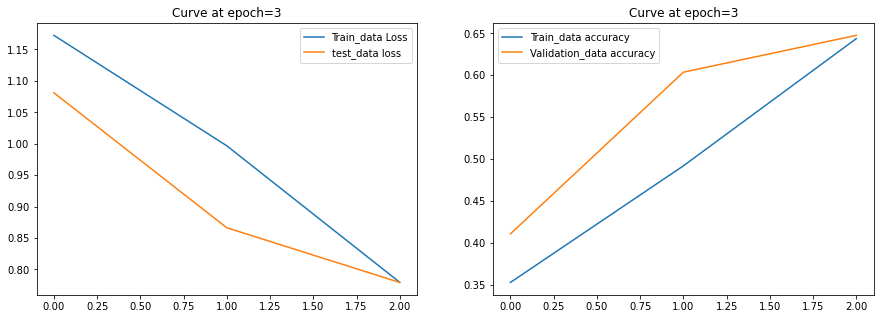

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(model_3.history['loss'], label = 'Train_data Loss')
plt.plot(model_3.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=3")
plt.legend()

plt.subplot(122)
plt.plot(model_3.history['accuracy'], label = 'Train_data accuracy')
plt.plot(model_3.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=3")
plt.legend()

# **XLM-RoBERTa Model: (BASE)**

In [ ]:
model1=model_defination(strategy,"jplu/tf-xlm-roberta-base")

In [ ]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
tf_roberta_model_1 (TFRobert ((None, 30, 768), (None,  278043648 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2307      
Total params: 278,045,955
Trainable params: 278,045,955
Non-trainable params: 0
_________________________________________________________________


**Tokenizing: With (xlm-roberta-base)**

In [ ]:
tokenizer1 = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')

In [ ]:
train_set1 = train_data[['premise','hypothesis']].values.tolist()
test_set1 = test_data[['premise','hypothesis']].values.tolist()

**Encoding the Data:**

In [ ]:
encoded_train1 = tokenizer1.batch_encode_plus(train_set1, pad_to_max_length=True, max_length=30)
encoded_test1 = tokenizer1.batch_encode_plus(test_set1, pad_to_max_length=True, max_length=30)

**Train and Test Split:**

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_train1['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_test1['input_ids']

**Pipeline:**

In [ ]:
train_df1 = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_df1 = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_df1 = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

**Training the Model:**

In [ ]:
#Epochs=3
model1_3 = model1.fit(train_df1,steps_per_epoch=step,validation_data=valid_df1,epochs=3)

Epoch 1/3
94/94 [==============================] - 23s 242ms/step - loss: 1.1756 - accuracy: 0.3492 - val_loss: 1.0914 - val_accuracy: 0.4142
Epoch 2/3
94/94 [==============================] - 11s 113ms/step - loss: 1.0587 - accuracy: 0.4502 - val_loss: 0.9619 - val_accuracy: 0.5300
Epoch 3/3
94/94 [==============================] - 11s 113ms/step - loss: 0.9381 - accuracy: 0.5465 - val_loss: 0.9175 - val_accuracy: 0.5781


In [ ]:
#Epochs=5
model1_5 = model1.fit(train_df1,steps_per_epoch=step,validation_data=valid_df1,epochs=5)

Epoch 1/5
94/94 [==============================] - 11s 112ms/step - loss: 0.8382 - accuracy: 0.6135 - val_loss: 0.9325 - val_accuracy: 0.5891
Epoch 2/5
94/94 [==============================] - 11s 114ms/step - loss: 0.7535 - accuracy: 0.6676 - val_loss: 0.9834 - val_accuracy: 0.5880
Epoch 3/5
94/94 [==============================] - 11s 115ms/step - loss: 0.6524 - accuracy: 0.7243 - val_loss: 1.1297 - val_accuracy: 0.5935
Epoch 4/5
94/94 [==============================] - 11s 113ms/step - loss: 0.5551 - accuracy: 0.7735 - val_loss: 1.1801 - val_accuracy: 0.5924
Epoch 5/5
94/94 [==============================] - 11s 113ms/step - loss: 0.4517 - accuracy: 0.8226 - val_loss: 1.3641 - val_accuracy: 0.5932


In [ ]:
#Epochs=10
model1_10 = model1.fit(train_df1,steps_per_epoch=step,validation_data=valid_df1,epochs=10)

Epoch 1/10
94/94 [==============================] - 11s 113ms/step - loss: 0.3727 - accuracy: 0.8594 - val_loss: 1.4570 - val_accuracy: 0.5886
Epoch 2/10
94/94 [==============================] - 11s 113ms/step - loss: 0.3070 - accuracy: 0.8834 - val_loss: 1.5789 - val_accuracy: 0.5974
Epoch 3/10
94/94 [==============================] - 11s 113ms/step - loss: 0.2350 - accuracy: 0.9136 - val_loss: 1.7543 - val_accuracy: 0.5858
Epoch 4/10
94/94 [==============================] - 11s 113ms/step - loss: 0.1848 - accuracy: 0.9332 - val_loss: 1.9454 - val_accuracy: 0.5861
Epoch 5/10
94/94 [==============================] - 11s 113ms/step - loss: 0.1404 - accuracy: 0.9489 - val_loss: 2.1294 - val_accuracy: 0.5864
Epoch 6/10
94/94 [==============================] - 11s 113ms/step - loss: 0.1258 - accuracy: 0.9551 - val_loss: 2.1129 - val_accuracy: 0.5938
Epoch 7/10
94/94 [==============================] - 11s 114ms/step - loss: 0.0952 - accuracy: 0.9663 - val_loss: 2.4818 - val_accuracy: 0.5916

**OBSERVATIONS:**

* Now if we see the last batch of each epoch at 3,5 and 10 we can see the following:

    * At epoch=3 loss has decreased and val_loss has decreased and accuracy has increased and val_accuracy has also increased.
    * At epoch = 5 loss is decreasing and val_loss is increasing. And accuracy is increasing whereas val_accuracy has reached constant.
    
    * At epoch = 10 is also similar to epoch -5 where the val_accuracy has reached a constant and has stopped increasing.
    
    Hence, we stop at epoch = 10 otherwise the model is getting overfitted.


**For the model : xlm-roberta-base we consider epoch =3.**

# **Visualizing of the model at epoch = 3 for better understanding:**

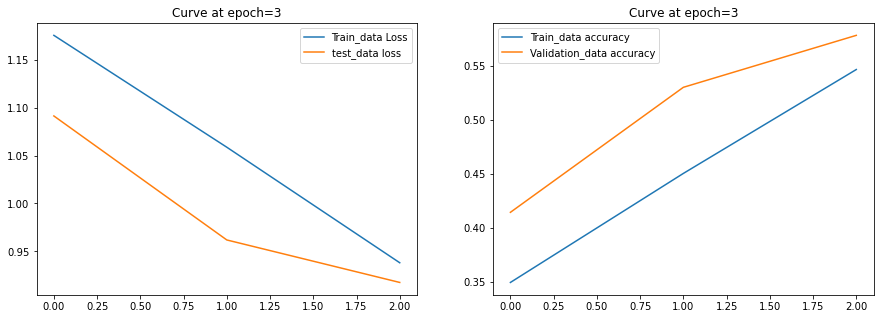

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(model1_3.history['loss'], label = 'Train_data Loss')
plt.plot(model1_3.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=3")
plt.legend()


plt.subplot(122)
plt.plot(model1_3.history['accuracy'], label = 'Train_data accuracy')
plt.plot(model1_3.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=3")
plt.legend()

# **For Model: xlm-roberta-base, let us experiment with XLMRobertaTokenizer for Tokenizing:**

In [ ]:
tokenizer2 = XLMRobertaTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')

In [ ]:
train_set2 = train_data[['premise','hypothesis']].values.tolist()
test_set2 = test_data[['premise','hypothesis']].values.tolist()

In [ ]:
encoded_train2 = tokenizer2.batch_encode_plus(train_set2, pad_to_max_length=True, max_length=30)
encoded_test2 = tokenizer2.batch_encode_plus(test_set2, pad_to_max_length=True, max_length=30)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_train2['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_test2['input_ids']

In [ ]:
train_df2 = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_df2 = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_df2 = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

In [ ]:
#Epochs=3
model1_1_3 = model1.fit(train_df2,steps_per_epoch=step,validation_data=valid_df2,epochs=3)

Epoch 1/3
94/94 [==============================] - 10s 110ms/step - loss: 0.4566 - accuracy: 0.8605 - val_loss: 0.3706 - val_accuracy: 0.8809
Epoch 2/3
94/94 [==============================] - 10s 111ms/step - loss: 0.3359 - accuracy: 0.8910 - val_loss: 0.3990 - val_accuracy: 0.8782
Epoch 3/3
94/94 [==============================] - 10s 111ms/step - loss: 0.2411 - accuracy: 0.9206 - val_loss: 0.4647 - val_accuracy: 0.8773


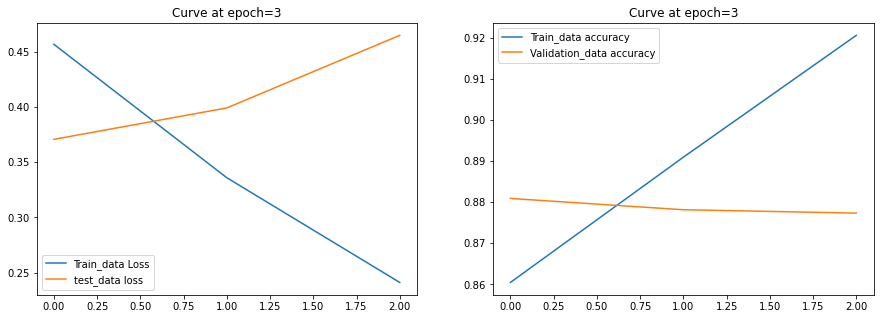

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(model1_1_3.history['loss'], label = 'Train_data Loss')
plt.plot(model1_1_3.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=3")
plt.legend()


plt.subplot(122)
plt.plot(model1_1_3.history['accuracy'], label = 'Train_data accuracy')
plt.plot(model1_1_3.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=3")
plt.legend()

**OBSERVATIONS:**

* For Model: xlm-roberta-base, experimenting with XLMRobertaTokenizer has not given any better outcome than the previous models.

* xlm-roberta-base with XLMRobertaTokenizer at epoch = 3 has performed the worst among other xlm-roberta models.

* Hence , we consider xlm-roberta-large at epoch = 3 as our final  xlm-roberta model.

# **Implementing Model: distilbert-base-multilingual-cased**

* For the above model defination.

* Running it on the train and test data respectively.

In [ ]:
model_b=model_defination(strategy,"distilbert-base-multilingual-cased")

In [ ]:
model_b.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 30, 768),)        134734080 
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 768)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2307      
Total params: 134,736,387
Trainable params: 134,736,387
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tokenizerb = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [ ]:
train_setb = train_data[['premise','hypothesis']].values.tolist()
test_setb = test_data[['premise','hypothesis']].values.tolist()

In [ ]:
encoded_trainb = tokenizerb.batch_encode_plus(train_setb, pad_to_max_length=True, max_length=30)
encoded_testb = tokenizerb.batch_encode_plus(test_setb, pad_to_max_length=True, max_length=30)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_trainb['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_testb['input_ids']

In [ ]:
train_dfb = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_dfb = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_dfb = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

In [ ]:
#Epochs=3
modelb = model_b.fit(train_dfb,steps_per_epoch=step,validation_data=valid_dfb,epochs=3)

Epoch 1/3
94/94 [==============================] - 13s 138ms/step - loss: 1.0961 - accuracy: 0.3754 - val_loss: 1.0491 - val_accuracy: 0.4337
Epoch 2/3
94/94 [==============================] - 6s 66ms/step - loss: 0.9916 - accuracy: 0.5096 - val_loss: 1.0074 - val_accuracy: 0.4992
Epoch 3/3
94/94 [==============================] - 6s 66ms/step - loss: 0.8889 - accuracy: 0.5889 - val_loss: 1.0341 - val_accuracy: 0.4959


In [ ]:
#Epochs=6
modelb_1 = model_b.fit(train_dfb,steps_per_epoch=step,validation_data=valid_dfb,epochs=6)

Epoch 1/6
94/94 [==============================] - 6s 65ms/step - loss: 0.7707 - accuracy: 0.6683 - val_loss: 1.0931 - val_accuracy: 0.5063
Epoch 2/6
94/94 [==============================] - 6s 65ms/step - loss: 0.6233 - accuracy: 0.7434 - val_loss: 1.2757 - val_accuracy: 0.4997
Epoch 3/6
94/94 [==============================] - 6s 67ms/step - loss: 0.4727 - accuracy: 0.8182 - val_loss: 1.4709 - val_accuracy: 0.4857
Epoch 4/6
94/94 [==============================] - 6s 67ms/step - loss: 0.3338 - accuracy: 0.8771 - val_loss: 1.6592 - val_accuracy: 0.4769
Epoch 5/6
94/94 [==============================] - 6s 66ms/step - loss: 0.2304 - accuracy: 0.9205 - val_loss: 1.9386 - val_accuracy: 0.4747
Epoch 6/6
94/94 [==============================] - 6s 66ms/step - loss: 0.1694 - accuracy: 0.9429 - val_loss: 2.1298 - val_accuracy: 0.4785


# **Visualization:**

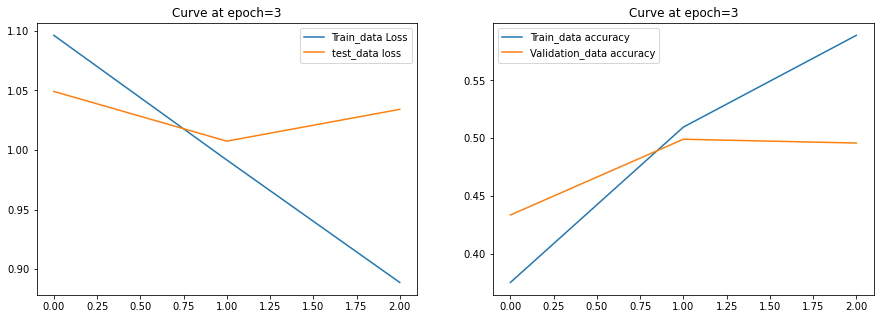

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(modelb.history['loss'], label = 'Train_data Loss')
plt.plot(modelb.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=3")
plt.legend()


plt.subplot(122)
plt.plot(modelb.history['accuracy'], label = 'Train_data accuracy')
plt.plot(modelb.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=3")
plt.legend()

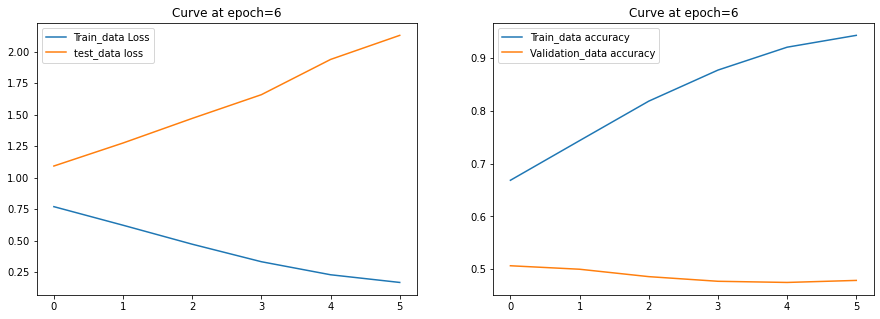

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(modelb_1.history['loss'], label = 'Train_data Loss')
plt.plot(modelb_1.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=6")
plt.legend()

plt.subplot(122)
plt.plot(modelb_1.history['accuracy'], label = 'Train_data accuracy')
plt.plot(modelb_1.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=6")
plt.legend()

**OBSERVATION:**

* At epoch=6 the model fits badly.

* Hence, we consider at epoch =3 and will further experiment with different parameters below.

 **Build the model with different parameters for Dense layer and activation along different loss value.**
 
 * Changing the MAX_LEN value to 80 to change the input_layer shape

In [ ]:
def model_defination(strategy,transformer):
    with strategy.scope():
        encoder = TFAutoModel.from_pretrained(transformer)
        input_layer = Input(shape=(80,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]
        cls_token = sequence_output[:, 0, :]
        output_layer = Dense(1, activation='sigmoid')(cls_token)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            Adam(lr=1e-5), 
            loss='binary_crossentropy', 
            metrics=['accuracy']
        )
        return model

In [ ]:
model_b1=model_defination(strategy,"distilbert-base-multilingual-cased")

In [ ]:
model_b1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 80)]              0         
_________________________________________________________________
tf_distil_bert_model_1 (TFDi ((None, 80, 768),)        134734080 
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 768)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tokenizerb_1 = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [ ]:
train_setb_1 = train_data[['premise','hypothesis']].values.tolist()
test_setb_1 = test_data[['premise','hypothesis']].values.tolist()

In [ ]:
encoded_trainb_1 = tokenizerb_1.batch_encode_plus(train_setb_1, pad_to_max_length=True, max_length=80)
encoded_testb_1 = tokenizerb_1.batch_encode_plus(test_setb_1, pad_to_max_length=True, max_length=80)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_trainb_1['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_testb_1['input_ids']

In [ ]:
train_dfb_1 = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_dfb_1 = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_dfb_1 = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

In [ ]:
#Epochs=3
model_b_1 = model_b1.fit(train_dfb_1,steps_per_epoch=step,validation_data=valid_dfb_1,epochs=3)

Epoch 1/3
94/94 [==============================] - 15s 157ms/step - loss: -0.1644 - accuracy: 0.3201 - val_loss: -1.2159 - val_accuracy: 0.3210
Epoch 2/3
94/94 [==============================] - 7s 77ms/step - loss: -2.5497 - accuracy: 0.3395 - val_loss: -2.8908 - val_accuracy: 0.3710
Epoch 3/3
94/94 [==============================] - 7s 78ms/step - loss: -4.0017 - accuracy: 0.3991 - val_loss: -3.3038 - val_accuracy: 0.4029


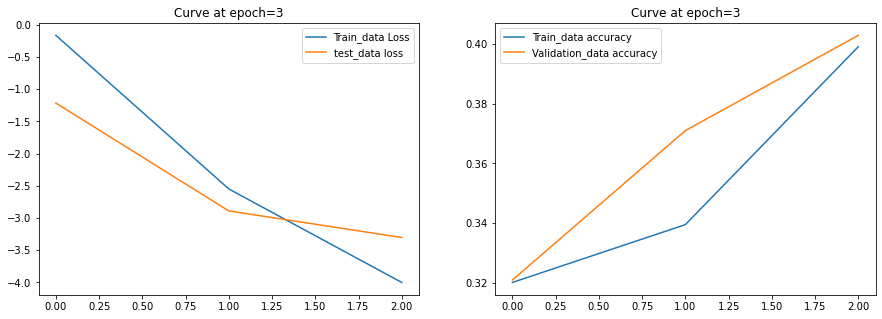

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(model_b_1.history['loss'], label = 'Train_data Loss')
plt.plot(model_b_1.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=3")
plt.legend()

plt.subplot(122)
plt.plot(model_b_1.history['accuracy'], label = 'Train_data accuracy')
plt.plot(model_b_1.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=3")
plt.legend()

**OBSERVATION:**


* At epoch = 3, the model "distilbert-base-multilingual-cased" is performing well with the different parameters used for building the model.

# **Implementing Model: "Bert-base-multilingual-cased"**

 **Building the Model:**

In [ ]:
def model_defination(strategy,transformer):
    with strategy.scope():
        bert_encoder = TFAutoModel.from_pretrained(transformer)
        input_layer = Input(shape=(30,), dtype=tf.int32, name="input_layer")
        sequence_output = bert_encoder(input_layer)[0]
        cls_token = sequence_output[:, 0, :]
        output_layer = Dense(3, activation='softmax')(cls_token)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            Adam(lr=1e-5), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

In [ ]:
model_bert=model_defination(strategy,"bert-base-multilingual-cased")

In [ ]:
model_bert.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 30, 768), (None,  177853440 
_________________________________________________________________
tf_op_layer_strided_slice_4  [(None, 768)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 2307      
Total params: 177,855,747
Trainable params: 177,855,747
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
train_set_bert = train_data[['premise','hypothesis']].values.tolist()
test_set_bert = test_data[['premise','hypothesis']].values.tolist()

In [ ]:
encoded_train_bert = tokenizerb_1.batch_encode_plus(train_set_bert, pad_to_max_length=True, max_length=30)
encoded_testb_bert = tokenizerb_1.batch_encode_plus(test_set_bert, pad_to_max_length=True, max_length=30)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_train_bert['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_testb_bert['input_ids']

In [ ]:
train_df_bert = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_df_bert = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_df_bert = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

In [ ]:
#Epochs=2
modelbert = model_bert.fit(train_df_bert,steps_per_epoch=step,validation_data=valid_df_bert,epochs=2)

Epoch 1/2
94/94 [==============================] - 21s 224ms/step - loss: 1.0885 - accuracy: 0.3904 - val_loss: 1.0368 - val_accuracy: 0.4761
Epoch 2/2
94/94 [==============================] - 9s 96ms/step - loss: 0.9396 - accuracy: 0.5564 - val_loss: 0.9925 - val_accuracy: 0.5206


In [ ]:
#Epochs=3
modelbert_3 = model_bert.fit(train_df_bert,steps_per_epoch=step,validation_data=valid_df_bert,epochs=3)

Epoch 1/3
94/94 [==============================] - 9s 95ms/step - loss: 0.8202 - accuracy: 0.6267 - val_loss: 1.0571 - val_accuracy: 0.5237
Epoch 2/3
94/94 [==============================] - 9s 97ms/step - loss: 0.6427 - accuracy: 0.7287 - val_loss: 1.2732 - val_accuracy: 0.5157
Epoch 3/3
94/94 [==============================] - 9s 96ms/step - loss: 0.4697 - accuracy: 0.8111 - val_loss: 1.4739 - val_accuracy: 0.5107


# **Visualization:**

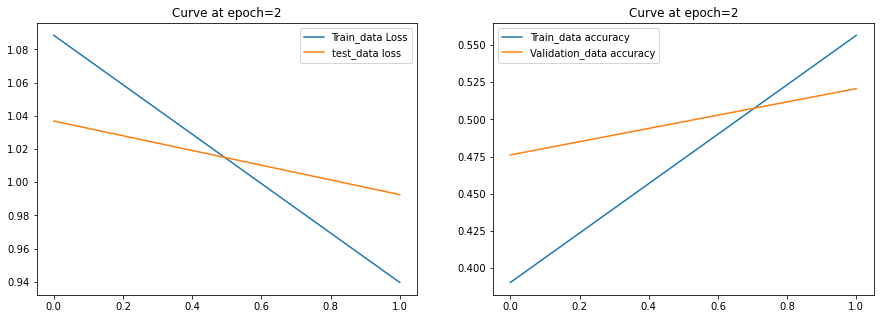

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(modelbert.history['loss'], label = 'Train_data Loss')
plt.plot(modelbert.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=2")
plt.legend()

plt.subplot(122)
plt.plot(modelbert.history['accuracy'], label = 'Train_data accuracy')
plt.plot(modelbert.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=2")
plt.legend()

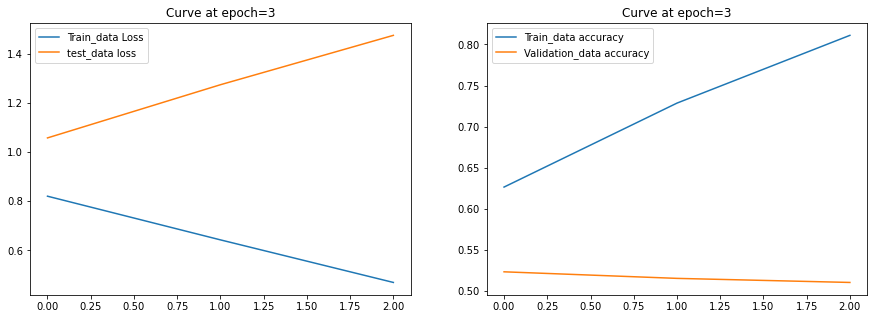

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(modelbert_3.history['loss'], label = 'Train_data Loss')
plt.plot(modelbert_3.history['val_loss'], label = 'test_data loss')
plt.title("Curve at epoch=3")
plt.legend()

plt.subplot(122)
plt.plot(modelbert_3.history['accuracy'], label = 'Train_data accuracy')
plt.plot(modelbert_3.history['val_accuracy'], label = 'Validation_data accuracy')
plt.title("Curve at epoch=3")
plt.legend()

**OBSERVATION:**


* For the model Bert-base-multilingual-cased the model performs well at epoch = 2

**Comparing the results of all the Models:**

 
 Model_names                             |  epoch value |  loss    | val_loss  | accuracy | val_accuracy |
 ----------------------------------------|--------------|----------|-----------|----------|--------------|
 XLM-RoBERTa Model: (Large)              |   3          | 0.77     | 0.77      |  0.64    |  0.64        |
 XLM-RoBERTa Model: (Base)               |   3          | 0.93     | 0.91      |  0.54    |  0.57        |
 distilbert-base-multilingual-cased      |   3          | 0.88     | 1.03      |  0.58    |  0.49        |
 distilbert-base-multilingual-cased(2nd) |   3          | -4.001   | -3.30     |  0.39    |  0.40        |     
 Bert-base-multilingual-cased            |   2          | 0.93     | 0.99      |  0.55    |  0.52        |


In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(model_3.history['loss'], label = 'Train_data Loss')

plt.plot(model_3.history['val_loss'], label = 'test_data loss')

plt.plot(model1_3.history['loss'], label = 'Train_data Loss')

plt.plot(model1_3.history['val_loss'], label = 'test_data loss')

plt.plot(modelb.history['loss'], label = 'Train_data Loss')

plt.plot(modelb.history['val_loss'], label = 'test_data loss')

plt.plot(model_b_1.history['loss'], label = 'Train_data Loss')

plt.plot(model_b_1.history['val_loss'], label = 'test_data loss')

plt.plot(modelbert.history['loss'], label = 'Train_data Loss')

plt.plot(modelbert.history['val_loss'], label = 'test_data loss')

plt.title("Curves of different models for loss and val_loss")

plt.legend()


ValueError: Invalid RGBA argument: 'sky blue'

<Figure size 1080x360 with 1 Axes>

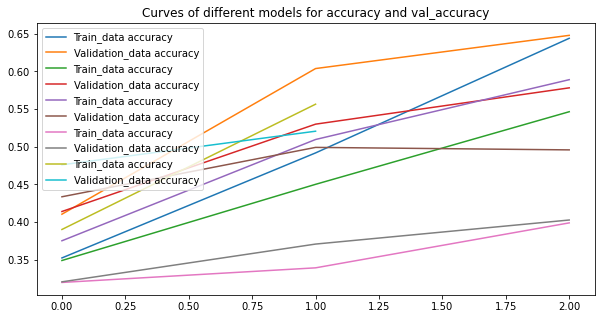

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(model_3.history['accuracy'], label = 'Train_data accuracy')

plt.plot(model_3.history['val_accuracy'], label = 'Validation_data accuracy')

plt.plot(model1_3.history['accuracy'], label = 'Train_data accuracy')

plt.plot(model1_3.history['val_accuracy'], label = 'Validation_data accuracy')

plt.plot(modelb.history['accuracy'], label = 'Train_data accuracy')

plt.plot(modelb.history['val_accuracy'], label = 'Validation_data accuracy')

plt.plot(model_b_1.history['accuracy'], label = 'Train_data accuracy')

plt.plot(model_b_1.history['val_accuracy'], label = 'Validation_data accuracy')

plt.plot(modelbert.history['accuracy'], label = 'Train_data accuracy')

plt.plot(modelbert.history['val_accuracy'], label = 'Validation_data accuracy')

plt.title("Curves of different models for accuracy and val_accuracy")

plt.legend()